In [ ]:
# Load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
# Ensure directory exists
os.makedirs("visualisations", exist_ok=True)

In [ ]:
# Load data
crash_facts = pd.read_excel("data/crash_fact_table.xlsx")
date_dimensions = pd.read_excel("data/date_dimension.xlsx")
location_dimensions = pd.read_excel("data/location_dimension.xlsx")

In [ ]:
# Data integrity validation

# If duplicates exist, remove them
crash_facts = crash_facts.drop_duplicates()
date_dimensions = date_dimensions.drop_duplicates()
location_dimensions = location_dimensions.drop_duplicates()

# Check fields 
print(crash_facts['Crash_Speed_Limit'].unique())
print(crash_facts['Crash_Severity'].unique())

# Type in a data entry for Medical Treatement (spelt with an extra full stop). Fixing
crash_facts['Crash_Severity'] = crash_facts['Crash_Severity'].str.replace('Medical treatment.', 'Medical treatment')
print(crash_facts['Crash_Severity'].unique())

# Re-order speeds to correct order
speed_order = ['0 - 50 km/h', '60 km/h', '70 km/h', '80 - 90 km/h', '100 - 110 km/h']
crash_facts['Crash_Speed_Limit'] = pd.Categorical(crash_facts['Crash_Speed_Limit'], categories=speed_order, ordered=True)

In [ ]:
# Analysing the frequency of crashes in each speed zone (note that this doesnt account for the fact that more people drive in lower speed limit zones)
plt.figure(figsize=(10, 5))
sns.countplot(y=crash_facts["Crash_Speed_Limit"], palette="viridis")
plt.xlabel("Count of Crashes")
plt.ylabel("Speed Limit")
plt.title("Distribution of Crashes by Speed Limit")
plt.savefig("visualisations/crash_frequency.png", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2771/1368793942.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



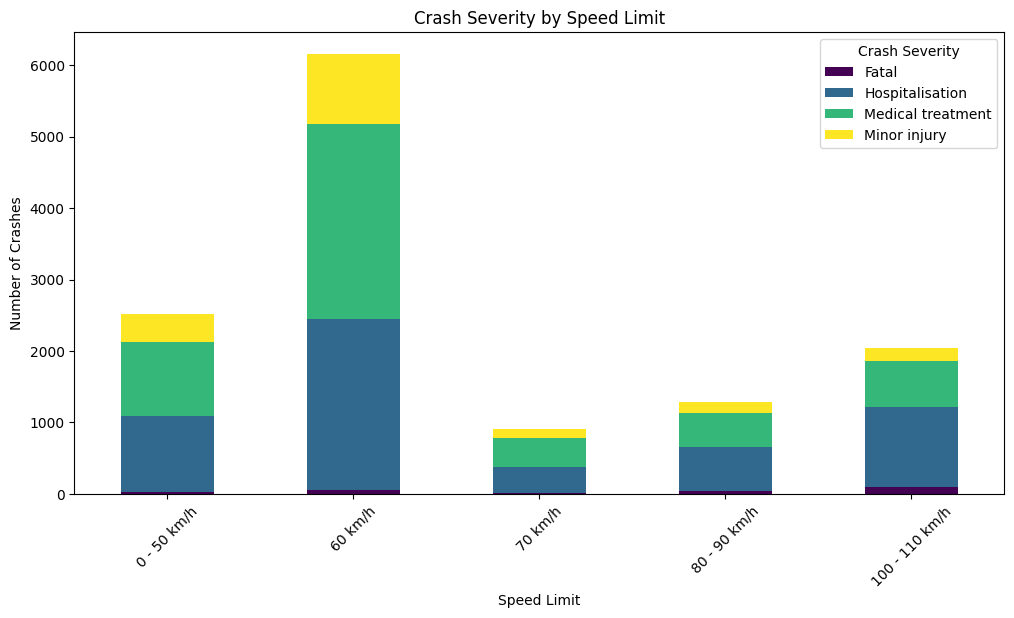

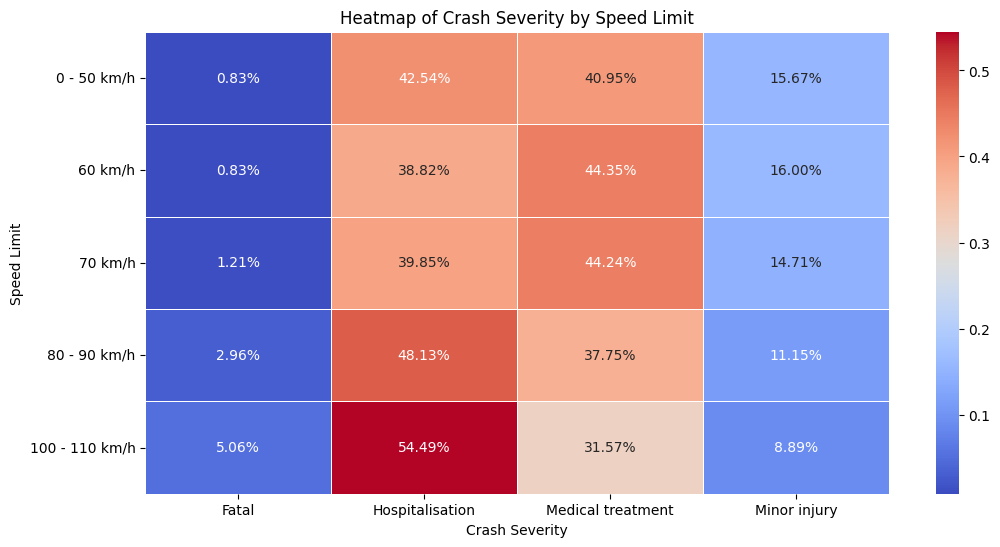

In [ ]:
# Create pivot table for stacked bar chart
severity_counts = crash_facts.pivot_table(index="Crash_Speed_Limit", columns="Crash_Severity", aggfunc="size", fill_value=0)

# Plot
severity_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Speed Limit")
plt.ylabel("Number of Crashes")
plt.title("Crash Severity by Speed Limit")
plt.legend(title="Crash Severity")
plt.xticks(rotation=45)
plt.savefig("visualisations/severity_speed_bar.png", bbox_inches="tight")
plt.show()


# For the heatmap, normalise the data to remove bias of areas with more total crashes due to more traffic.
heatmap_data = severity_counts.div(severity_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Crash Severity")
plt.ylabel("Speed Limit")
plt.title("Heatmap of Crash Severity by Speed Limit")
plt.savefig("visualisations/severity_speed_heat.png", bbox_inches="tight")
plt.show()

In [ ]:
# The relationship between Crash Type and Crash Severity. For example, what types of crashes produce the most or least severe outcomes.
# Create pivot table for stacked bar chart
severity_counts = crash_facts.pivot_table(index="Crash_Type", columns="Crash_Severity", aggfunc="size", fill_value=0)

# Plot
severity_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Crash Type")
plt.ylabel("Number of Crashes")
plt.title("Crash Severity by Crash Type")
plt.legend(title="Crash Severity")
plt.xticks(rotation=45)
plt.savefig("visualisations/severity_type_bar.png", bbox_inches="tight")
plt.show()


# For the heatmap, normalise the data to remove bias of areas with more total crashes due to more traffic.
heatmap_data = severity_counts.div(severity_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Crash Severity")
plt.ylabel("Crash Type")
plt.title("Heatmap of Crash Severity by Crash Type")
plt.savefig("visualisations/severity_type_heat.png", bbox_inches="tight")
plt.show()

In [ ]:
# Calculate the number of crashes (and their Crash Severity) for each month of 2018.

# Merge the two dataframes on 'date_key' to get year and month
merged_data = crash_facts.merge(date_dimensions[['Date_Key', 'Crash_Year', 'Crash_Month']], on='Date_Key', how='left')

# Filter data for 2018
merged_data_2018 = merged_data[merged_data['Crash_Year'] == 2018]

# Group by 'year', 'month' and 'Crash_Severity', and count the number of crashes
monthly_crashes = merged_data_2018.groupby(['Crash_Year', 'Crash_Month', 'Crash_Severity']).size().reset_index(name='crash_count')
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_crashes['Crash_Month'] = pd.Categorical(monthly_crashes['Crash_Month'], categories=month_order, ordered=True)

# Create a pivot table to get the crash count by month and severity
monthly_crashes_pivot = monthly_crashes.pivot_table(index=['Crash_Month'], columns='Crash_Severity', values='crash_count', aggfunc='sum', fill_value=0)

# Plot stacked bar chart
monthly_crashes_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

plt.title('Monthly Crash Severity in 2018')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.legend(title='Crash Severity')
plt.tight_layout()
plt.savefig('visualisations/monthly_crash_severity.png', bbox_inches="tight")
plt.show()

In [ ]:
# Merge the two datasets on 'Location_Key'
merged_data = crash_facts.merge(location_dimensions[['Location_Key', 'Loc_Suburb']], on='Location_Key', how='left')

# Group by 'Loc_Suburb' and 'Crash_Severity' to count crashes by severity for each suburb
severity_by_suburb = merged_data.groupby(['Loc_Suburb', 'Crash_Severity']).size().unstack(fill_value=0)

# Calculate total number of crashes for each suburb
suburb_total_crashes = merged_data['Loc_Suburb'].value_counts()

# Add the total crashes column to the severity DataFrame
severity_by_suburb['Total_Crashes'] = suburb_total_crashes

# Sort the suburbs by total crashes in descending order and get the top 10
top_10_suburbs = severity_by_suburb.sort_values(by='Total_Crashes', ascending=False).head(10).reset_index()

# Print the top 10 suburbs with severity breakdown and total crashes
print(top_10_suburbs)

# Plot stacked bar chart
ax = top_10_suburbs.drop(columns='Total_Crashes').plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")

# Set x-axis labels to the 'Loc_Suburb' column
ax.set_xticklabels(top_10_suburbs['Loc_Suburb'], rotation=45)

plt.xlabel("Suburb")
plt.ylabel("Number of Crashes")
plt.title("Top 10 Suburbs with the Most Crashes by Severity")
plt.xticks(rotation=45)
plt.legend(title="Crash Severity")
plt.savefig('visualisations/top10_suburbs_barchart.png', bbox_inches="tight")
plt.show()

In [ ]:
# Geospatial heat map visulisation for suburbs
merged_data = crash_facts.merge(location_dimensions[['Location_Key', 'Crash_Longitude_GDA94', 'Crash_Latitude_GDA94']], on='Location_Key', how='left')

# Create the density map
fig = px.density_map(merged_data, 
                        lat='Crash_Latitude_GDA94', 
                        lon='Crash_Longitude_GDA94', 
                        color_continuous_scale="Viridis",
                        title="Geographic Heatmap of Crashes")
# Adjust map appearance
fig.update_layout(
    width=800,  
    height=800, 
)
fig.update_traces(
    radius=8,
)
fig.show()